## Prueba de modelos ##

### Version 4: Modelo con 2 DER, planificación anual, granularidad horaria ###

Si el modelo tiene que optimizar el balance por horas, tiene 8640 VD, pero sigue teniendo 2 VD binarias

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandapower as pp

In [4]:
import os

In [5]:
import pandas as pd

In [6]:
import pyomo.environ as pe

In [7]:
import math

In [8]:
import random

In [9]:
import itertools

In [10]:
import matplotlib.pyplot as plt

In [11]:
import numpy as np

In [45]:
import ModelWriters.simple_busbar_model 

In [13]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)
b12 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE")

pp.create_sgen(net, b11, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2)
b32 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)

#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)



2

In [14]:
 pp.runpp(net)

In [15]:
print(net.res_bus.vm_pu)
print(net.res_line)

0    1.000000
1    0.999206
2    0.996501
3    1.002824
4    0.998497
5    0.993536
6    0.999583
Name: vm_pu, dtype: float64
   p_from_mw  q_from_mvar   p_to_mw     q_to_mvar     pl_mw   ql_mvar  \
0   0.276189    -0.058072 -0.275956  4.891292e-02  0.000233 -0.009159   
1   0.350956    -0.023913 -0.350000 -2.477944e-15  0.000956 -0.023913   
2  -0.149573    -0.057583  0.150000  1.065188e-15  0.000427 -0.057583   
3   0.775911     0.307919 -0.774624 -3.134920e-01  0.001287 -0.005573   
4   0.854624     0.313492 -0.850000 -3.300000e-01  0.004624 -0.016508   
5   0.220093     0.044267 -0.220000 -5.000000e-02  0.000093 -0.005733   

   i_from_ka   i_to_ka      i_ka  vm_from_pu  va_from_degree  vm_to_pu  \
0   0.012344  0.012268  0.012344    1.000000        0.000000  0.999206   
1   0.015398  0.015362  0.015398    0.999206       -0.015073  0.996501   
2   0.007010  0.006542  0.007010    1.000000        0.000000  1.002824   
3   0.036512  0.036605  0.036605    1.000000        0.000000  0.99

In [16]:
print(net)

This pandapower network includes the following parameter tables:
   - bus (7 elements)
   - load (3 elements)
   - sgen (3 elements)
   - ext_grid (1 element)
   - line (6 elements)
 and the following results tables:
   - res_bus (7 elements)
   - res_line (6 elements)
   - res_ext_grid (1 element)
   - res_load (3 elements)
   - res_sgen (3 elements)


In [17]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,0.15
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,0.10
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,0.10


Agregamos los parámetros del modelo a los elementos de la red.

In [18]:
def net_add_optfw(net):
    #agregamos parámetros para el costo inicial en forma de un valor constante ic_0 y un valor función lineal de la potencia ic_1
    tables = [net.ext_grid, net.load, net.sgen]

    for t in tables: 
        #initial cost
        t['ic_0_mu'] = 0.0
        t['ic_1_mu'] = 0.0
        #idem para costo operativo
        t['oc_0_mu'] = 0.0
        t['oc_1_mu'] = 0.0
        #power rating:
        t['pr_mw'] = 1.0
        #available power, per unit of power rating
        t['pa_pu'] = 1.0
        #operating (actual) power
        t['po_mw'] = 0.0
        #Must be optimized?
        t['sizeable'] = False
        #model
        t['model'] = None
        #las restricciones pueden ser ninguna, o una lista de restricciones tipo pyomo
        t['constraints'] = None


In [19]:
net_add_optfw(net)

Vemos como queda por ejemplo el elemento de red externa:

In [20]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,pr_mw,pa_pu,po_mw,sizeable,model,constraints
0,None,0,1.0,0.0,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,None,None


Defino una función normal de Python para que nos va a dar la componente lineal del costo de la energía

Variables que define el modelo:

y para el año

d para el día del año

h para la hora del día

dt la granularidad del modelo, en horas


temp la temperatura

wv la velocidad del viento

I la irradiación solar


eg el crecimiento económico en pu respecto al año 0


Estas variables llegan como parámetros en forma de diccionario en el argumento 'model_status' (ver este nombre)

Todas las funciones reciben este argumento, la lógica de la función indica que valor retorna. Pr ejemplo, si la granularidad es 24 h, debe retornar el valor medio del parámetro producido.

In [21]:
def oc_1_ext_grid(model_status={}):
    #modelo sencillo con dos precios, uno entre 0 a 18 y otro de 18 a 24
    res = 0.0
    sx = 1e-6
    if 'h' in model_status:
        h = model_status['h']
        if 0.0 <= h and h < 18.0:
            res = 3600.0*sx
        elif 18 <= h and h < 24.0:
            res = 5400.0*sx
        else:
            raise ValueError("Hour outside model range")
    else:
        raise ValueError("Hour not defined")
    
    return res

In [22]:
#test:
#m_s = {'y': 0, 'd': 180, 'h': 14.0, 'dt': 1.0, 'temp': 12.0, 'wv': 10.0, 'eg': 1.0}

#oc_1_ext_grid(m_s)

In [23]:
#20 hs: 5400
#m_s['h'] = 20.5
#oc_1_ext_grid(m_s)

In [24]:
#25 hs: error
#m_s['h'] = 25
#oc_1_ext_grid(m_s)

In [25]:
net.ext_grid['oc_1_mu'][0] = oc_1_ext_grid
net.ext_grid['name'][0] = 'SET'
#net.ext_grid['pr_mw'][0] = 1.5
net.ext_grid['pr_mw'][0] = 5.0


In [26]:
net.ext_grid

,name,bus,vm_pu,va_degree,in_service,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,pr_mw,pa_pu,po_mw,sizeable,model,constraints
0,SET,0,1.0,0.0,True,0.0,0.0,0.0,<function oc_1_ext_grid at 0x000001809EB419D0>,5.0,1.0,0.0,False,None,None


In [27]:
def demand(model_status={}):
    #modelo sencillo en forma de escalones
    #devuelvr la fracción de la carga empleada
    #se considera que la carga tiene una variabilidad aleatoria de un 20% y es mayor en verano e invierno en un 30%
    #la variabilidad total puede ser 1.3*1.2=1.56 verano-invierno o 0.7*0.8 = 0.56 otoño-primavera, 
    res = 0.0
    if 'h' in model_status:
        h = model_status['h']
        if 0.0 <= h and h < 6.0:
            res = 0.2
        elif 6.0 <= h and h < 8.0:
            res = 0.4
        elif 8.0 <= h and h < 18.0:
            res = 0.5
        elif 18.0 <= h and h < 22.0:
            res = 1.0
        elif 22.0 <= h and h < 24.0:
            res = 0.3            
        else:
            raise ValueError("Hour outside model range")
    else:
        raise ValueError("Hour not defined")
    
    #estacionalidad
    if 'd' in model_status:
        d = model_status['d']
        #se asume que el día de mayor consumo es el inicio del verano y del invierno (21/12 y 21/07), por eso sumo 10 días el dia 0
        #divido por 180 porque hay dos picos en el año y paso a radianes
        estacionalidad = 1 + 0.3*math.cos((d + 10.0)/180.0*2*math.pi)  
    else:
        raise ValueError("Day not defined")
    res = res * estacionalidad
    
    #Aleatoriedad:
    res = res*random.uniform(0.8, 1.2)
    return res

In [28]:
net.load['pr_mw'][0] = net.load['p_mw'][0]
net.load['pa_pu'][0] = demand
net.load['name'][0] = 'Tornquinst'
net.load['pr_mw'][1] = net.load['p_mw'][1]
net.load['pa_pu'][1] = demand
net.load['name'][1] = 'Bell Ville'
net.load['pr_mw'][2] = net.load['p_mw'][2]
net.load['pa_pu'][2] = demand
net.load['name'][2] = 'City Bell'


In [29]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,pr_mw,pa_pu,po_mw,sizeable,model,constraints
0,Tornquinst,2,0.35,0.00,0.0,0.0,NaN,1.0,True,wye,0.0,0.0,0.0,0.0,0.35,<function demand at 0x0000018089533670>,0.0,False,None,None
1,Bell Ville,5,0.85,0.33,0.0,0.0,NaN,1.0,True,wye,0.0,0.0,0.0,0.0,0.85,<function demand at 0x0000018089533670>,0.0,False,None,None
2,City Bell,6,0.22,0.05,0.0,0.0,NaN,1.0,True,wye,0.0,0.0,0.0,0.0,0.22,<function demand at 0x0000018089533670>,0.0,False,None,None


In [30]:
def solar_output(model_status={}):
    #modelo sencillo
    #usando los datos de radiacion solar entregada por el modelo
    #considero el valor normal 1000 W/m2
    res = 0.0
    if 'I' in model_status:
        I = model_status['I']
        if 0.0 <= I and I < 1200:
            res = I / 1000.0
        else:
            raise ValueError("Solar radiation outside model range")
    else:
        raise ValueError("Solar radiation not defined")
    
    return res

In [31]:
#test:
##m_s = {'y': 0, 'd': 180, 'h': 43.0, 'dt': 1.0, 'temp': 12.0, 'I':950.0,  'wv': 10.0, 'eg': 1.0}
##solar_output(m_s)

In [32]:
net.sgen['name'][0] = 'PV1'
net.sgen['pa_pu'][0] = solar_output
net.sgen['ic_0_mu'][0] = 2
net.sgen['ic_1_mu'][0] = 0.75
net.sgen['oc_0_mu'][0] = 0.0
net.sgen['oc_1_mu'][0] = 500e-6
net.sgen['sizeable'][0] = True


net.sgen['name'][2] = 'PV2'
net.sgen['pa_pu'][2] = solar_output
net.sgen['ic_0_mu'][2] = 2
net.sgen['ic_1_mu'][2] = 0.75
net.sgen['oc_0_mu'][2] = 0.0
net.sgen['oc_1_mu'][2] = 500e-6
net.sgen['sizeable'][2] = True


In [33]:
def wind_output(model_status={}):
    #modelo sencillo
    #devuelvr la fracción de la potencia entregada en función del tiempo
    #no toma en cuenta la radicación solar ni la temperatura
    res = 0.0
    if 'wv' in model_status:
        wv = model_status['wv']
        if 0.0 <= wv and wv < 3.0:
            res = 0.0
        elif 3.0 <= wv and wv < 15.0:
            res = (wv-3.0)/(15.0-3.0)
        elif 15.0 <= wv and wv < 25.0:
            res = 1.0
        else:
            res = 0.0
    else:
        raise ValueError("Wind Velocity not defined")
    
    return res

In [34]:

net.sgen['name'][1] = 'WT1'
net.sgen['pa_pu'][1] = wind_output
net.sgen['ic_0_mu'][1] = 5.0
net.sgen['ic_1_mu'][1] = 3.0
net.sgen['oc_0_mu'][1] = 0.0
net.sgen['oc_1_mu'][1] = 700e-6
net.sgen['sizeable'][1] = True

In [35]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,...,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,pr_mw,pa_pu,po_mw,sizeable,model,constraints
0,PV1,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,...,2.0,0.75,0.0,0.0005,1.0,<function solar_output at 0x000001809C6D6B80>,0.0,True,None,None
1,WT1,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,...,5.0,3.00,0.0,0.0007,1.0,<function wind_output at 0x000001809EB41280>,0.0,True,None,None
2,PV2,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,...,2.0,0.75,0.0,0.0005,1.0,<function solar_output at 0x000001809C6D6B80>,0.0,True,None,None


## Construcción de Escenarios

In [36]:
dias = 365
años = 5

In [37]:
#el rango de horas:
T_i = range(24)

#el rango de dias:
Dias_i = range(dias)

Escenarios_i = range(len(T_i)*len(Dias_i))

In [38]:
def solar_irradiance_simulation(d, h):
    #simula las horas de sol, la intensidad y los dias multiplos de 5 esta nublado, con un 20% de la radiacion
    #a todo esto se le aplica una aleatoriedad del 80 al 100%
    #los coeficientes son aproximados para Buenos Aires
    radiacion = 1000.0
    
    estacionalidad = 0.75 + 0.25*math.cos((d + 10.0)/365.0*2*math.pi)  
    
    if d % 5 == 0 :
        nubosidad = 0.2
    else:
        nubosidad = 1.0
        
    aleatoriedad = random.uniform(0.8, 1.0)
    
    salida = 7.0 - 1.1*math.cos((d + 10.0)/365.0*2*math.pi)    #es una aproximacion, no basada en modelos matematicos
    puesta = 19.0 + 1.1*math.cos((d + 10.0)/365.0*2*math.pi)
    
    temporalidad = 0.0
    if salida <= h and h <= puesta:
        temporalidad = math.sin((h-salida)/(puesta-salida)*math.pi)
        
    return radiacion*estacionalidad*nubosidad*aleatoriedad*temporalidad

In [39]:
m_s_base = [{'y': 0, 'd': 0, 'dd':1.0, 'h': 0.0, 'dt': 1.0, 'temp': 20.0, 'I':1000.0, 'wv': 10.0, 'eg': 1.0}]

registros = len(Dias_i)*len(T_i)

Escenarios =  pd.DataFrame(m_s_base, index = Escenarios_i)

reg = 0
for d in Dias_i:
    for h in T_i:
        Escenarios['d'][reg] = d
        Escenarios['h'][reg] = h
        Escenarios['I'][reg] = solar_irradiance_simulation(d, h)
        Escenarios['wv'][reg] = random.uniform(1.0, 20.0)
        reg += 1

In [40]:
Escenarios

,y,d,dd,h,dt,temp,I,wv,eg
0,0,0,1.0,0.0,1.0,20.0,0.000000,9.377089,1.0
1,0,0,1.0,1.0,1.0,20.0,0.000000,14.011142,1.0
2,0,0,1.0,2.0,1.0,20.0,0.000000,14.986604,1.0
3,0,0,1.0,3.0,1.0,20.0,0.000000,19.934850,1.0
4,0,0,1.0,4.0,1.0,20.0,0.000000,16.810411,1.0
...,...,...,...,...,...,...,...,...,...
8755,0,364,1.0,19.0,1.0,20.0,217.813512,11.547395,1.0
8756,0,364,1.0,20.0,1.0,20.0,18.718883,12.255436,1.0
8757,0,364,1.0,21.0,1.0,20.0,0.000000,6.758554,1.0
8758,0,364,1.0,22.0,1.0,20.0,0.000000,3.957407,1.0


## Construcción del Modelo

Construccion automatica del modelo
Es un modelo de dimensionamiento de 3 DERs (WT+PV)

In [48]:
model_writer = ModelWriters.simple_busbar_model.SimpleModelWriter(net, Escenarios)

In [49]:
model = model_writer.create_model()

In [50]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

#opt = pe.SolverFactory('cplex')
opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\jmsar\AppData\Local\Temp\tmp0pvcdw4m.glpk.raw --wglp C:\Users\jmsar\AppData\Local\Temp\tmp6t1tjo35.glpk.glp
 --cpxlp C:\Users\jmsar\AppData\Local\Temp\tmp_y3rd99b.pyomo.lp
Reading problem data from 'C:\Users\jmsar\AppData\Local\Temp\tmp_y3rd99b.pyomo.lp'...
C:\Users\jmsar\AppData\Local\Temp\tmp_y3rd99b.pyomo.lp:253098: warning: lower bound of variable 'x35041' redefined
C:\Users\jmsar\AppData\Local\Temp\tmp_y3rd99b.pyomo.lp:253098: warning: upper bound of variable 'x35041' redefined
35044 rows, 35047 columns, 77865 non-zeros
3 integer variables, all of which are binary
253101 lines were read
Writing problem data to 'C:\Users\jmsar\AppData\Local\Temp\tmp6t1tjo35.glpk.glp'...
253093 lines were written
GLPK Integer Optimizer, v4.65
35044 rows, 35047 columns, 77865 non-zeros
3 integer variables, all of which are binary
Preprocessing...
20920 rows, 16544 columns, 45737 non-zeros
3 integer variabl

In [51]:
model_writer.backconfigure_network()

In [52]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,...,ic_0_mu,ic_1_mu,oc_0_mu,oc_1_mu,pr_mw,pa_pu,po_mw,sizeable,model,constraints
0,PV1,1,0.075,0.025,NaN,1.0,False,wye,True,0.000000,...,2.0,0.75,0.0,0.0005,0.000000,<function solar_output at 0x000001809C6D6B80>,0.0,True,None,None
1,WT1,3,0.150,0.000,NaN,1.0,True,wye,True,1.620147,...,5.0,3.00,0.0,0.0007,1.620147,<function wind_output at 0x000001809EB41280>,0.0,True,None,None
2,PV2,4,0.080,0.000,NaN,1.0,False,wye,True,0.000000,...,2.0,0.75,0.0,0.0005,0.000000,<function solar_output at 0x000001809C6D6B80>,0.0,True,None,None


In [53]:
Resultados = model_writer.get_scenes_results()

In [54]:
Resultados

,SET,Tornquinst,Bell Ville,City Bell,WT1
0,0.000000,0.095049,0.257202,0.048943,0.401195
1,0.000000,0.082300,0.235182,0.062307,0.379789
2,0.000000,0.078660,0.240827,0.051574,0.371061
3,0.000000,0.103590,0.256472,0.065222,0.425285
4,0.000000,0.092009,0.208129,0.049515,0.349654
...,...,...,...,...,...
8755,0.682873,0.412486,1.091491,0.332899,1.154003
8756,0.563525,0.399650,1.139870,0.273602,1.249597
8757,1.050486,0.410392,0.920273,0.227272,0.507451
8758,0.406234,0.157071,0.307891,0.070534,0.129262


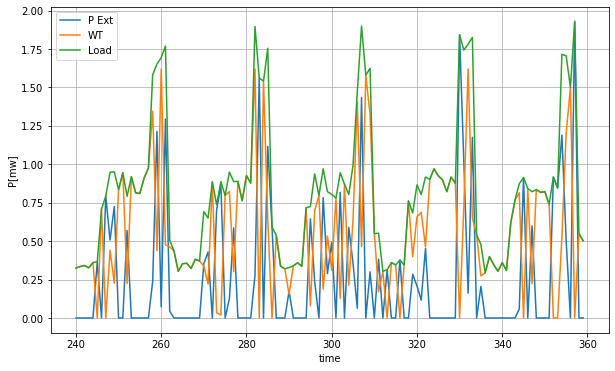

In [55]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
ax.plot(Resultados['SET'][240:360], label = 'P Ext')
ax.plot(Resultados['WT1'][240:360], label = 'WT')
ax.plot(Resultados['Tornquinst'][240:360]+Resultados['Bell Ville'][240:360]+Resultados['City Bell'][240:360], label = 'Load')

#ax.plot(Resultados['time'][240:360], Resultados['p_mw_PV'][240:360], label = 'PV')
#ax.plot(Resultados['time'][240:360], Resultados['p_mw_Load'][240:360], label = 'Load')

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()